In [1]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"

In [2]:
objs = wr.s3.list_objects(s3_collection_path + "seekingAlpha.seekingAlphaBulkMetrics/", boto3_session=session)

In [3]:
from tqdm import tqdm
df_alphas = []
for path in tqdm(objs):
	new_df = wr.s3.read_parquet(path, boto3_session=session)
	new_df["date"] = path.split("/")[-1].split(".")[0]
	df_alphas.append(new_df)

df_alpha = pd.concat(df_alphas, axis = 0)

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_77902/1055745706.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 14%|█▍        | 1/7 [00:00<00:03,  1.58it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_77902/1055745706.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/

In [4]:
df_alpha["date"].value_counts()

date
2023-10-05    1603
2023-10-03    1600
2023-10-06    1598
2023-10-04    1595
2023-10-02    1576
2023-09-28    1570
2023-09-29    1567
Name: count, dtype: int64

In [5]:
all_dates = df_alpha["date"].sort_values().unique()
all_dates

array(['2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03',
       '2023-10-04', '2023-10-05', '2023-10-06'], dtype=object)

In [6]:
overlap_tickers = set(df_alpha["ticker"].tolist())

for d in tqdm(all_dates):
	day_df = df_alpha[df_alpha["date"]==d]
	overlap_tickers = overlap_tickers.intersection(set(day_df["ticker"].tolist()))
	print(len(overlap_tickers))

len(overlap_tickers)

100%|██████████| 7/7 [00:00<00:00, 328.08it/s]

1570
1553
1543
1538
1531
1529
1523


1523

In [7]:
filtered_df = df_alpha[df_alpha["ticker"].isin(overlap_tickers)]
filtered_df.shape

(10661, 266)

In [8]:
day_df_0 = filtered_df[filtered_df["date"]=="2023-09-28"].set_index("ticker").select_dtypes(float)
day_df_1 = filtered_df[filtered_df["date"]=="2023-09-29"].set_index("ticker").select_dtypes(float)

In [9]:
corr_cols = []

for d in all_dates:
	day_df = filtered_df[filtered_df["date"]==d].set_index("ticker").select_dtypes(float)
	cols = day_df_0.corrwith(day_df)
	corr_cols.append(cols)

<Axes: >

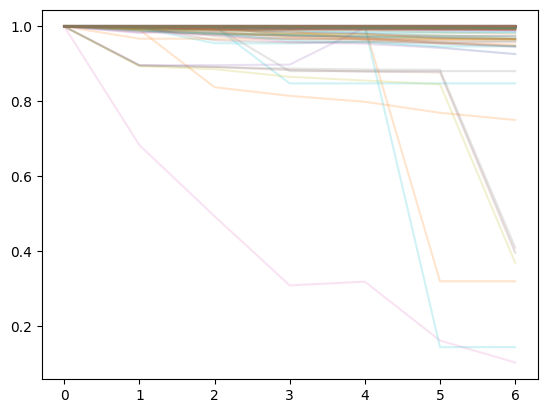

In [11]:
import matplotlib.pyplot as plt
corr_df = pd.DataFrame(corr_cols)
corr_df.plot(legend=None, alpha = 0.2)


In [28]:
high_autocorr_columns = corr_df.columns[(corr_df.min() > 0.99999)]

In [29]:
high_autocorr_columns.shape

(64,)

In [30]:
high_autocorr_columns

Index(['assets_turnover_avg_5y', 'capex_change', 'capex_change_avg_5y',
       'capex_to_sales', 'capex_to_sales_avg_5y', 'cash_per_share',
       'cash_per_share_ttm', 'cf_payout_avg_5y', 'diluted_eps',
       'diluted_eps_growth_avg_5y', 'div_payout_nongaap_fy1_avg_5y',
       'dividend_consistency_avg_5y', 'dividend_coverage_ratio_ttm',
       'dividend_growth_avg_5y', 'dps_yoy_avg_5y', 'earnings_yield_avg_5y',
       'ebit_margin', 'ebit_margin_avg_5y', 'ebitda_margin',
       'ebitda_margin_avg_5y', 'eps_gaap_annual_growth_yoy', 'ev_ebit_avg_5y',
       'ev_ebit_fy1_avg_5y', 'ev_ebitda_avg_5y', 'ev_ebitda_fy1_avg_5y',
       'ev_sales_fy1_avg_5y', 'fcf_yield_avg_5y', 'fixed_asset_turnover_ttm',
       'gross_margin', 'gross_margin_avg_5y', 'int_cover',
       'levered_fcf_margin', 'levered_fcf_margin_avg_5y',
       'net_asset_to_pension_liabilities_annual', 'net_inc_per_employee',
       'net_lt_debt_ebitda_avg_5y', 'net_lt_debt_tot_assets_avg_5y',
       'net_margin', 'net_margi

Interestingly, there are many many highly auto-correlated features. I think we can think of it like a division into 2 tasks:

1. good long-term return stocks with auto-correlated features (ex: long-term features)
2. short term fluctuations with not as auto-correlated features (ex: short-term features)